In [3]:
#install YOLO repo
!git clone https://github.com/ultralytics/yolov5.git

Cloning into 'yolov5'...


In [19]:
!pip install -r yolov5/requirements.txt
#needed to install pytorch with cuda 11.3 support
!pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113 --upgrade

You should consider upgrading via the 'C:\Users\John\Documents\repos\chronam yolov5\yolo\Scripts\python.exe -m pip install --upgrade pip' command.


Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu113


You should consider upgrading via the 'C:\Users\John\Documents\repos\chronam yolov5\yolo\Scripts\python.exe -m pip install --upgrade pip' command.


In [14]:
import torch
from matplotlib import pyplot as plt
import numpy as np
import cv2

Using cache found in C:\Users\John/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2022-5-21 Python-3.9.12 torch-1.11.0+cpu CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


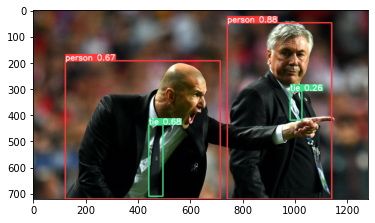

In [15]:
#test it is working on a known example
model = torch.hub.load('ultralytics/yolov5', 'yolov5s')  # or yolov5n - yolov5x6, custom
img = 'https://ultralytics.com/images/zidane.jpg'  # or file, Path, PIL, OpenCV, numpy, list
results = model(img)

%matplotlib inline 
plt.imshow(np.squeeze(results.render()))
plt.show()

In [ ]:
#get our test data
gwget --recursive -A .jp2 --no-parent --no-host-directories --cut-dirs 2 --reject index.html* --no-check-certificate https://chroniclingamerica.loc.gov/data/batches/dlc_flavory_ver01/

In [ ]:
import os
from pathlib import Path
os.environ['OPENCV_IO_ENABLE_JASPER']='True' #has to be set before importing cv2 otherwise it won't read the variable
import cv2

startingDir = 'dlc_flavory_ver01'

#rename files and move to top directory
for root,dirs,files in os.walk(startingDir):
  for file in files:
    date = os.path.basename(os.path.normpath(root))
    newName = "-".join([date[:4], date[4:6], date[6:8], date[8:], file])
    dst = os.path.join(startingDir, newName)
    fullPath = os.path.join(root, file)
    print("renaming ", fullPath, " to ", dst)
    os.rename(fullPath, dst)
  
for root,dirs,files in os.walk(startingDir):
  for file in files:
    basename = Path(file).stem
    fullPath = os.path.join(root, file)
    img = cv2.imread(fullPath)
    newPath = os.path.join(root, "%s.jpeg" % basename)
    print("re-writing ", fullPath, " to ", newPath)
    cv2.imwrite(newPath, img, [cv2.IMWRITE_JPEG_QUALITY, 50])
    
    #delete the jp2 file
    #os.remove(fullPath)

In [5]:
#setup the program we will use to create the label data
!git clone https://github.com/tzutalin/labelImg

Cloning into 'labelImg'...


In [ ]:
#label images - we are just labeling columns and titles

#https://github.com/ultralytics/yolov5/wiki/Tips-for-Best-Training-Results#dataset :
#Images per class. ≥ 1500 images per class recommended
#Instances per class. ≥ 10000 instances (labeled objects) per class recommended
#etc...
!cd labelImg && pyrcc5 -o libs/resources.py resources.qrc

In [6]:
#convert the labelImg xml files to YOLO formatted .txt files and delete the XML files
from xml.dom import minidom
import os
import glob

lut={}
lut["column"] =0
lut["title"]  =1


def convert_coordinates(size, box):
    dw = 1.0/size[0]
    dh = 1.0/size[1]
    x = (box[0]+box[1])/2.0
    y = (box[2]+box[3])/2.0
    w = box[1]-box[0]
    h = box[3]-box[2]
    x = x*dw
    w = w*dw
    y = y*dh
    h = h*dh
    return (x,y,w,h)

for fname in glob.glob("dlc_flavory_ver01\\*.xml"):     
    xmldoc = minidom.parse(fname)

    fname_out = (fname[:-4]+'.txt')

    with open(fname_out, "w") as f:

        itemlist = xmldoc.getElementsByTagName('object')
        size = xmldoc.getElementsByTagName('size')[0]
        width = int((size.getElementsByTagName('width')[0]).firstChild.data)
        height = int((size.getElementsByTagName('height')[0]).firstChild.data)

        for item in itemlist:
            # get class label
            classid =  (item.getElementsByTagName('name')[0]).firstChild.data
            if classid in lut:
                label_str = str(lut[classid])
            else:
                label_str = "-1"
                print ("warning: label '%s' not in look-up table" % classid)

            # get bbox coordinates
            xmin = ((item.getElementsByTagName('bndbox')[0]).getElementsByTagName('xmin')[0]).firstChild.data
            ymin = ((item.getElementsByTagName('bndbox')[0]).getElementsByTagName('ymin')[0]).firstChild.data
            xmax = ((item.getElementsByTagName('bndbox')[0]).getElementsByTagName('xmax')[0]).firstChild.data
            ymax = ((item.getElementsByTagName('bndbox')[0]).getElementsByTagName('ymax')[0]).firstChild.data
            b = (float(xmin), float(xmax), float(ymin), float(ymax))
            bb = convert_coordinates((width,height), b)
            #print(bb)

            f.write(label_str + " " + " ".join([("%.6f" % a) for a in bb]) + '\n')
    #delete the xml file
    #os.remove(fname)
    print ("wrote %s" % fname_out)

In [ ]:
#split the images into test and train sets
TRAIN_PATH = os.path.join('dlc_flavory_ver01', 'train')
TEST_PATH = os.path.join('dlc_flavory_ver01', 'test')

# Split the data into test, train, validation sets... 80/20
annotatedFiles = list()

for root,dirs,files in os.walk('dlc_flavory_ver01'):
  for file in files:
    if file.lower().endswith('.txt'):
        basename = Path(file).stem
        annotatedFiles.append([os.path.join(root, "%s.jpeg" % basename), os.path.join(root, "%s.txt" % basename)])
        

# This gives the 80/20 train test split
training_list, testing_list = train_test_split(annotatedFiles, test_size=0.2, random_state=11)
flattened_training_list = sum(training_list, [])
flattened_testing_list = sum(testing_list, [])

#remove old train/test data if there is any
shutil.rmtree(TRAIN_PATH)
shutil.rmtree(TEST_PATH)

#create the train and test data directories
os.makedirs(TRAIN_PATH)
os.makedirs(TEST_PATH)

#copy the image and the label data into the test/train directories
for training_file in flattened_training_list:
    shutil.copyfile(training_file, os.path.join(TRAIN_PATH, os.path.basename(training_file)))
for testing_file in flattened_testing_list:
    shutil.copyfile(testing_file, os.path.join(TEST_PATH, os.path.basename(testing_file)))

In [16]:
#create our dataset.yml - needed for YOLO to know where the training and test data is
with open("dataset.yaml", "w") as file1:
    file1.write("""# Train/val/test sets as 1) dir: path/to/imgs, 2) file: path/to/imgs.txt, or 3) list: [path/to/imgs1, path/to/imgs2, ..]
path: dlc_flavory_ver01  # dataset root dir
train: train  # train images (relative to 'path') 128 images
val: train  # val images (relative to 'path') 128 images
test: test # test images (optional)

# Classes
nc: 2  # number of classes
names: [ 'column', 'title' ]  # class names""")

In [20]:
#use to make sure it is setup correctly and is using GPU. You will want to enable GPU for faster training
print("use GPU? ", torch.cuda.is_available())

use GPU?  False


In [26]:
#train using our custom label data
print("cd yolov5\npython train.py --img 640 --batch 16 --epochs 2000 --data ../dataset.yaml --weights yolov5s.pt")

cd yolov5
python train.py --img 640 --batch 16 --epochs 2000 --data ../dataset.yaml --weights yolov5s.pt


YOLOv5  2022-5-21 Python-3.9.12 torch-1.11.0+cpu CPU

Fusing layers... 
Model summary: 213 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


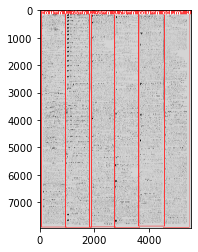

In [25]:
#show our model using an example image - this was after 213 epochs
model = torch.hub.load('yolov5', 'custom', source='local', path='yolov5\\runs\\train\\exp\\weights\\best.pt')
img = 'test\\1842-04-23-01-0007.jpeg'  # or file, Path, PIL, OpenCV, numpy, list
results = model(img)

%matplotlib inline 
plt.imshow(np.squeeze(results.render()))
plt.show()